In [1]:
"""
This file is to present all the code and results for the submitted paper
"""

'\nThis file is to present all the code and results for the submitted paper\n'

In [2]:
import csv
import numpy as np
from matplotlib import pyplot as plt

# Step 1 - loading the functions for processing data

In [3]:
"""loading the function for loading data"""

def load_csv_data(data_path, sub_sample=False):
    """Loads data and returns y (class labels), tX (features) and ids (event ids)"""
    y = np.genfromtxt(data_path, delimiter=",", skip_header=1, dtype=str, usecols=1)
    x = np.genfromtxt(data_path, delimiter=",", skip_header=1)
    ids = x[:, 0].astype(np.int)
    input_data = x[:, 2:]

    # convert class labels from strings to binary (-1,1)
    yb = np.ones(len(y))
    yb[np.where(y=='b')] = -1
    
    # sub-sample
    if sub_sample:
        yb = yb[::50]
        input_data = input_data[::50]
        ids = ids[::50]
    return yb, input_data, ids

In [4]:
"""loading the function for predicting and submission data"""

def predict_labels(weights, data):
    """Generates class predictions given weights, and a test data matrix"""
    y_pred = np.dot(data, weights)
    y_pred[np.where(y_pred <= 0)] = -1
    y_pred[np.where(y_pred > 0)] = 1
    return y_pred

def create_csv_submission(ids, y_pred, name):
    """
    Creates an output file in .csv format for submission to Kaggle or AIcrowd
    Arguments: ids (event ids associated with each prediction)
               y_pred (predicted class labels)
               name (string name of .csv output file to be created)
    """
    with open(name, 'w') as csvfile:
        fieldnames = ['Id', 'Prediction']
        writer = csv.DictWriter(csvfile, delimiter=",", fieldnames=fieldnames)
        writer.writeheader()
        for r1, r2 in zip(ids, y_pred):
            writer.writerow({'Id':int(r1),'Prediction':int(r2)})

In [5]:
"""loading the function for split data and data wragling"""

def split_data(x, y, ratio, myseed):
    
    """split the train dataset to train and validation dataset based on the split ratio."""
    
    # set seed
    # ratio = 0.75
    np.random.seed(myseed)
    # generate random indices
    num_row = len(x)
    indices = np.random.permutation(num_row)
    index_split = int(np.floor(ratio * num_row))
    index_train = indices[: index_split]
    index_val = indices[index_split:]
    # create split
    x_tr = x[index_train]
    x_val = x[index_val]
    y_tr = y[index_train]
    y_val = y[index_val]
    
    return x_tr, x_val, y_tr, y_val

def standlization(data):
    mu = np.mean(data, axis=0)
    sigma = np.std(data, axis=0)
    return (data - mu) / sigma

def fix_null(tx):
    for feature in range(tx.shape[1]):
        row_indices = np.where(tx[:,feature] == -999.0)[0]
        clean_data = [x for x in tx[:,feature] if x != -999.0]
        #clean_data = np.mean(tx[np.where(tx_predict[:, 0] != -999)[0], 0])
        mean = np.mean(clean_data)
        # print(f"feature {feature} mean:{mean}\n")
        # print(row_indices)
        # print("\n")
        tx[row_indices,feature] = mean
    return tx


def standardize(x):
    # Standardize the original data set.
    # standardize the data into [-1,1]
    mean_x = np.mean(x, axis = 0)
    x = x - mean_x
    std_x = np.std(x, axis = 0)
    x = x / std_x
    return x, mean_x, std_x

def detect_outliers(tx):
    outlier_indices = np.array([]) 
    for feature in range(tx.shape[1]):
        _, mean, std = standardize(tx[:,feature])
        #row_indices = np.where(np.absolute(tx[:,feature]-mean) > 3*std)[0]
        row_indices_big = np.where(tx[:,feature]-mean > 3*std)[0]
        row_indices_small = np.where(mean - tx[:,feature] > 3*std)[0]
        tx[row_indices_big] = mean + 3*std
        tx[row_indices_small] = mean - 3*std
    return tx

def expand_dimen(tx,k): # (x1, x2, x3 ...) -> (x1, x1^2, x^k)
    tx_base = tx
    for i in range(2, k+1):
        tx = np.hstack((tx, np.power(tx_base, i)))
    return tx

def feature_aug(tx, k):
    tx_new = expand_dimen(tx, k)
    return tx_new

# step 2 - visualize the raw data

In [6]:
y_train, x_train, ids = load_csv_data(r"train.csv", sub_sample=False)
x_train = np.c_[np.ones((x_train.shape[0], 1)), x_train]

In [7]:
X = x_train[:1500,[17,2]]
Y = y_train[:1500]

In [8]:
def visualization(y, x, mean_x, std_x,save_name, is_LR=False):
    """visualize the raw data as well as the classification result."""
    fig = plt.figure(figsize=(5,5))
    # plot raw data
    x = de_standardize(x, mean_x, std_x)
    ax1 = fig.add_subplot(1, 1, 1)
    males = np.where(y == -1)
    females = np.where(y == 1)
    ax1.scatter(
        x[males, 0], x[males, 1],
        marker='.', color=[1, 0.06, 0.06], s=10, label="b")
    ax1.scatter(
        x[females, 0], x[females, 1],
        marker='.', color=[0.06, 0.06, 1], s=10, label="s")
    ax1.set_xlabel("feature 17")
    ax1.set_ylabel("feature 2")
    ax1.legend()

def standardize1(x):
    """Standardize the original data set."""
    mean_x = np.mean(x, axis=0)
    x = x - mean_x
    std_x = np.std(x, axis=0)
    x = x / std_x
    return x, mean_x, std_x

def de_standardize(x, mean_x, std_x):
    """Reverse the procedure of standardization."""
    x = x * std_x
    x = x + mean_x
    return x

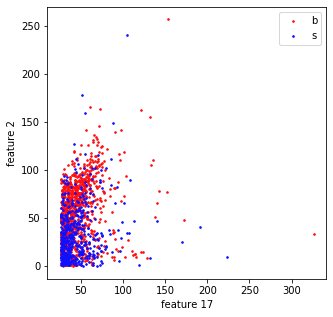

In [9]:
def least_square_classification_demo(y, x, mean_x, std_x):
    # visualize
    visualization(y, x, mean_x, std_x,"classification_by_least_square")

x, mean_x, std_x = standardize1(X)
least_square_classification_demo(Y, x, mean_x, std_x)
plt.savefig("visualize_point")

# step 3 - using six methods to predict

## loading data with poly only for ridge regression

In [10]:
y_train, x_train, ids = load_csv_data(r"train.csv", sub_sample=False)
x_train = fix_null(x_train)
x_train = detect_outliers(x_train) # delete outliers
x_train = standlization(x_train) # data standlization
x_train = np.c_[np.ones((x_train.shape[0], 1)), x_train]
x_tr, x_val, y_tr, y_val = split_data(x_train, y_train, 0.75, 50)

## a) Linear Regression

In [11]:
# load functions
def compute_mse(e):
    """Calculate the mse for vector e."""
    return 1/2*np.mean(e**2)

def compute_gradient(y, tx, w):
    """Compute the gradient."""
    err = y - tx.dot(w)
    grad = -tx.T.dot(err) / len(err)
    return grad, err

def predict_labels(weights, data):
    """Generates class predictions given weights, and a test data matrix"""
    y_pred = np.dot(data, weights)
    y_pred[np.where(y_pred <= 0)] = -1
    y_pred[np.where(y_pred > 0)] = 1
    return y_pred

def _accuracy(Y_pred, Y_label):
    # This function calculates prediction accuracy
    acc = 1 - (np.mean(np.abs(Y_pred - Y_label))/2)
    return acc

def gradient_descent(y, tx, initial_w, max_iters, gamma):
    """Gradient descent algorithm."""
    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w
    for n_iter in range(max_iters):
        # compute loss, gradient
        grad, err = compute_gradient(y, tx, w)
        loss = compute_mse(err)
        # update w by gradient descent
        w = w - gamma * grad
        # store w and loss
        ws.append(w)
        losses.append(loss)
        # print("Gradient Descent({bi}/{ti}): loss={l}, w0={w0}, w1={w1}".format(bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]))

    return  w

In [12]:
# Define the parameters of the algorithm.
max_iters = 200
gamma = 0.001
# Initialization
w_initial = np.zeros((x_tr.shape[1]))
# Start gradient descent.
w  = gradient_descent(y_tr, x_tr, w_initial, max_iters, gamma)
# test accuracy
y_pred = predict_labels(w, x_val)
print("test prediction acc", _accuracy(y_pred, y_val))

test prediction acc 0.6728160000000001


## b) Linear Regression SGD

In [13]:
# load functions

def compute_stoch_gradient(y, tx, w):
    """Compute a stochastic gradient from just few examples n and their corresponding y_n labels."""
    err = y - tx.dot(w)
    grad = -tx.T.dot(err) / len(err)
    return grad, err

def stochastic_gradient_descent(
        y, tx, initial_w, batch_size, max_iters, gamma):
    """Stochastic gradient descent."""
    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w
    
    for n_iter in range(max_iters):
        for y_batch, tx_batch in batch_iter(y, tx, batch_size=batch_size, num_batches=1):
            # compute a stochastic gradient and loss
            grad, _ = compute_stoch_gradient(y_batch, tx_batch, w)
            # update w through the stochastic gradient update
            w = w - gamma * grad
            # calculate loss
            loss = compute_loss(y, tx, w)
            # store w and loss
            ws.append(w)
            losses.append(loss)

        #print("SGD({bi}/{ti}): loss={l}".format(bi=n_iter, ti=max_iters - 1, l=loss))
    return w

def compute_loss(y, tx, w):
    """Calculate the loss.

    You can calculate the loss using mse or mae.
    """
    e = y - tx.dot(w)
    return compute_mse(e)

def batch_iter(y, tx, batch_size, num_batches=1, shuffle=True):
    """
    Generate a minibatch iterator for a dataset.
    Takes as input two iterables (here the output desired values 'y' and the input data 'tx')
    Outputs an iterator which gives mini-batches of `batch_size` matching elements from `y` and `tx`.
    Data can be randomly shuffled to avoid ordering in the original data messing with the randomness of the minibatches.
    Example of use :
    for minibatch_y, minibatch_tx in batch_iter(y, tx, 32):
        <DO-SOMETHING>
    """
    data_size = len(y)

    if shuffle:
        shuffle_indices = np.random.permutation(np.arange(data_size))
        shuffled_y = y[shuffle_indices]
        shuffled_tx = tx[shuffle_indices]
    else:
        shuffled_y = y
        shuffled_tx = tx
    for batch_num in range(num_batches):
        start_index = batch_num * batch_size
        end_index = min((batch_num + 1) * batch_size, data_size)
        if start_index != end_index:
            yield shuffled_y[start_index:end_index], shuffled_tx[start_index:end_index]

In [14]:
# Define the parameters of the algorithm.
max_iters = 200
gamma = 0.001
batch_size = 8
# Initialization
w_initial = np.zeros((x_tr.shape[1]))
# Start SGD.
w = stochastic_gradient_descent(y_tr, x_tr, w_initial, batch_size, max_iters, gamma)
# test accuracy
y_pred = predict_labels(w, x_val)
print("test prediction acc", _accuracy(y_pred, y_val))

test prediction acc 0.650416


## c) Least Squares

In [15]:
def least_squares(y, tx):
    """Calculate the least squares solution.
       returns mse, and optimal weights.
    """
    a = tx.T.dot(tx)
    b = tx.T.dot(y)
    w = np.linalg.solve(a, b)
    mse = compute_loss(y, tx, w)
    return w, mse

def test_squares(y,x):
    
    w, mse = least_squares(y, x)
    # print("Solution LS: ", w, "MSE: ", mse)
    return w

In [16]:
w = test_squares(y_tr, x_tr)
# test accuracy
y_pred = predict_labels(w, x_val)
print("test prediction acc", _accuracy(y_pred, y_val))

test prediction acc 0.737776


## d) Rigde Regression

In [17]:
y_train, x_train, ids = load_csv_data(r"train.csv", sub_sample=False)
x_train = fix_null(x_train)
x_train = detect_outliers(x_train) # delete outliers
# x_train = feature_aug(x_train, 8)
x_train = standlization(x_train) # data standlization
x_train = np.c_[np.ones((x_train.shape[0], 1)), x_train]
x_tr, x_val, y_tr, y_val = split_data(x_train, y_train, 0.75, 99)

In [18]:
def ridge_regression(y, tx, lambda_):
    """implement ridge regression."""
    aI = 2 * tx.shape[0] * lambda_ * np.identity(tx.shape[1])
    # aI =  lambda_ * np.sum(w*w)
    a = tx.T.dot(tx) + aI
    b = tx.T.dot(y)
    return np.linalg.solve(a, b)

def plot_train_test(train_errors, test_errors, lambdas):
    """
    train_errors, test_errors and lambas should be list (of the same size) the respective train error and test error for a given lambda,
    * lambda[0] = 1
    * train_errors[0] = RMSE of a ridge regression on the train set
    * test_errors[0] = RMSE of the parameter found by ridge regression applied on the test set
    
    degree is just used for the title of the plot.
    """
    plt.semilogx(lambdas, train_errors, color='b', marker='*', label="Train error")
    plt.semilogx(lambdas, test_errors, color='r', marker='*', label="Val error")
    plt.xlabel("lambda")
    plt.ylabel("RMSE")
    plt.title("Ridge regression " )
    leg = plt.legend(loc=1, shadow=True)
    leg.draw_frame(False)
    
def ridge_regression_demo(x, y, ratio, seed):
    """ridge regression demo."""
    # define parameter
    lambdas = np.logspace(-5, 0, 15) 
    # p.logspace() 
    # split data
    x_tr, x_te, y_tr, y_te = split_data(x, y, ratio, seed)
    # ridge regression with different lambda
    rmse_tr = []
    rmse_te = []
    for ind, lambda_ in enumerate(lambdas):
        # ridge regression
        weight = ridge_regression(y_tr, x_tr, lambda_)
        rmse_tr.append(np.sqrt(2 * compute_loss(y_tr, x_tr, weight)))  
        rmse_te.append(np.sqrt(2 * compute_loss(y_te, x_te, weight)))

        #print("proportion={p}, lambda={l:.3f}, Training RMSE={tr:.3f}, Testing RMSE={te:.3f}".format( # 学一下输出手法
        #      p=ratio, l=lambda_, tr=rmse_tr[ind], te=rmse_te[ind]))
    plot_train_test(rmse_tr, rmse_te, lambdas)

def ridge_regression_demo_new(x, y):
    """ridge regression demo."""
    # define parameter
    lambdas = 0.00001
    # p.logspace() 
    # split data
    # ridge regression with different lambda
    weight = ridge_regression(y, x, lambdas)
    return weight

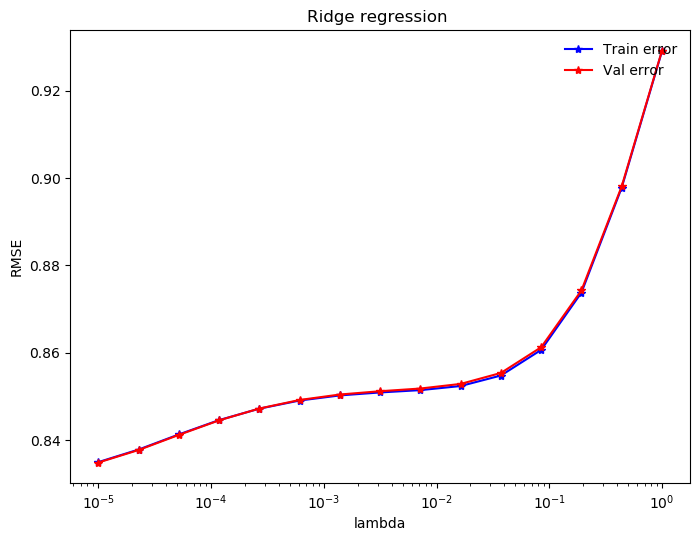

In [19]:
seed = 5
split_ratio = 0.75
plt.figure(figsize=(8,6),dpi=100)
ridge_regression_demo(x_train, y_train,split_ratio, seed)
plt.savefig('ridge regression')

In [20]:
w = ridge_regression_demo_new(x_tr, y_tr)
y_pred = predict_labels(w, x_val)
print("test prediction acc", _accuracy(y_pred, y_val))

test prediction acc 0.7323200000000001


## e) Logistic Regression SGD

### first we need some changes for data because the lable prediction for it is mostly likely to be 0 or 1

In [21]:
y_train, x_train, ids = load_csv_data(r"train.csv", sub_sample=False)
x_train = fix_null(x_train)
x_train = detect_outliers(x_train) # delete outliers
# x_train = feature_aug(x_train, 8)
x_train = standlization(x_train) # data standlization
x_train = np.c_[np.ones((x_train.shape[0], 1)), x_train]
x_tr, x_val, y_tr, y_val = split_data(x_train, y_train, 0.75, 99)
y_tr[y_tr == -1] = 0
y_val[y_val == -1] = 0

In [22]:
def _f(X, w):
    # This is the logistic regression function, parameterized by w and b
    # Output:
    #     predicted probability of each row of X being positively labeled, shape = [batch_size, ]
    return _sigmoid(np.matmul(X, w))

def _predict(X, w):
    # This function returns a truth value prediction for each row of X 
    # by rounding the result of logistic regression function.
    return np.round(_f(X, w)).astype(np.int)
    
def _accuracy(Y_pred, Y_label):
    # This function calculates prediction accuracy
    acc = 1 - np.mean(np.abs(Y_pred - Y_label))
    return acc

In [23]:
## loading the function

In [24]:
def sigmoid(t):
    """apply sigmoid function on t."""
    return 1.0 / (1 + np.exp(-t))

def _sigmoid(t):
    """apply sigmoid function on t."""
    return 1.0 / (1 + np.exp(-t))

def calculate_loss(y, tx, w):
    """compute the cost by negative log likelihood."""
    pred = sigmoid(tx.dot(w))
    loss = y.T.dot(np.log(pred)) + (1 - y).T.dot(np.log(1 - pred))
    return np.squeeze(- loss)


def learn_by_compute_stoch_gradient(y, tx, w):
    """Compute a stochastic gradient from just few examples n and their corresponding y_n labels."""
    err = y - tx.dot(w)
    pred = sigmoid(tx.dot(w))
    grad = tx.T.dot(pred - y) / len(err)
    
    return grad

def logistic_regression_stocastic_penalized_gradient_descent(y, tx, initial_w, batch_size, max_iters, gamma):
    """Stochastic gradient descent."""
    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w    
    for n_iter in range(max_iters):
        for y_batch, tx_batch in batch_iter(y, tx, batch_size=batch_size, num_batches=1):
            # compute a stochastic gradient and loss
            grad  = learn_by_compute_stoch_gradient(y_batch, tx_batch, w)
            # update w through the stochastic gradient update
            w = w - gamma * grad
            # calculate logistic regression loss
            loss = calculate_loss(y, tx, w)
            # store w and loss
            ws.append(w)
            losses.append(loss)
    return w

In [25]:
max_iters = 500
gamma = 0.001
batch_size = 8
# Initialization
initial_w = np.zeros((31))
w = logistic_regression_stocastic_penalized_gradient_descent(y_tr, x_tr, initial_w, batch_size, max_iters, gamma)
y_pred = _predict(x_val, w)
print("test prediction acc", _accuracy(y_pred, y_val))

test prediction acc 0.670544


## f) Logistic Regression SGD - Ridge

In [26]:
y_train, x_train, ids = load_csv_data(r"train.csv", sub_sample=False)
x_train = fix_null(x_train)
x_train = detect_outliers(x_train) # delete outliers
# x_train = feature_aug(x_train, 8)
x_train = standlization(x_train) # data standlization
x_train = np.c_[np.ones((x_train.shape[0], 1)), x_train]
x_tr, x_val, y_tr, y_val = split_data(x_train, y_train, 0.75, 99)
y_tr[y_tr == -1] = 0
y_val[y_val == -1] = 0

In [27]:
def calculate_loss_ridge(y, tx, w, lamda):
    """compute the cost by negative log likelihood."""
    pred = sigmoid(tx.dot(w))
    loss = y.T.dot(np.log(pred)) + (1 - y).T.dot(np.log(1 - pred)) + lamda * np.sum(w*w)
    return np.squeeze(- loss)


def learn_by_compute_stoch_gradient(y, tx, w):
    """Compute a stochastic gradient from just few examples n and their corresponding y_n labels."""
    err = y - tx.dot(w)
    pred = sigmoid(tx.dot(w))
    grad = tx.T.dot(pred - y) / len(err)
    
    return grad

def logistic_ridge_regression_stocastic_penalized_gradient_descent(y, tx, initial_w, batch_size, max_iters, gamma, lamda):
    """Stochastic gradient descent."""
    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w    
    for n_iter in range(max_iters):
        for y_batch, tx_batch in batch_iter(y, tx, batch_size=batch_size, num_batches=1):
            # compute a stochastic gradient and loss
            grad  = learn_by_compute_stoch_gradient(y_batch, tx_batch, w)
            # update w through the stochastic gradient update
            w = w - gamma * grad
            # calculate logistic regression loss
            loss = calculate_loss_ridge(y, tx, w, lamda)
            # store w and loss
            ws.append(w)
            losses.append(loss)
    return w

In [28]:
max_iters = 500
gamma = 0.001
batch_size = 8
lamda = 0.01
# Initialization
initial_w = np.zeros((31))
w = logistic_ridge_regression_stocastic_penalized_gradient_descent(y_tr, x_tr, initial_w, batch_size, max_iters, gamma, lamda)
y_pred = _predict(x_val, w)
print("test prediction acc", _accuracy(y_pred, y_val))

test prediction acc 0.670544


## g) a comparison between the six methods without poly

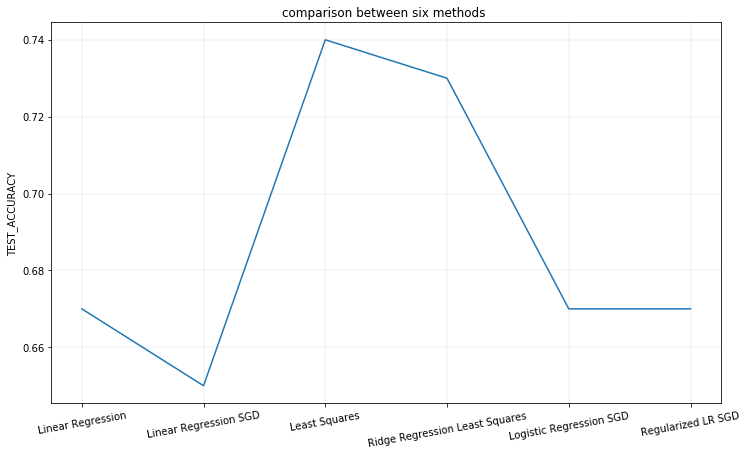

In [29]:
# Put the test accuracy for the six methods in a list and compare them
plt.figure(figsize=(12,7))
te_acc = [0.67, 0.65, 0.74, 0.73, 0.67, 0.67] 
x = ["Linear Regression","Linear Regression SGD","Least Squares",
     "Ridge Regression Least Squares","Logistic Regression SGD","Regularized LR SGD"]
plt.xticks(rotation = 10)
plt.grid(linestyle='-', linewidth=0.2)
plt.ylabel("TEST_ACCURACY")
plt.title("comparison between six methods " )
plt.plot(x,te_acc)
plt.savefig('comparison between six methods')

# step 4 use poly  with the best model and its ridge form

from the figure at the end of step 2, we can find the best model is least squres, so we use it and its ridge ression form to use poly

In [30]:
y_train, x_train, ids = load_csv_data(r"train.csv", sub_sample=False)
x_train = fix_null(x_train)
x_train = detect_outliers(x_train) # delete outliers
x_train = standlization(x_train) # data standlization
# x_train = np.c_[np.ones((x_train.shape[0], 1)), x_train]
x_tr, x_val, y_tr, y_val = split_data(x_train, y_train, 0.75, 50)

In [31]:
def _accuracy(Y_pred, Y_label):
    # This function calculates prediction accuracy
    acc = 1 - (np.mean(np.abs(Y_pred - Y_label))/2)
    return acc

def least_squares(y, tx):
    """Calculate the least squares solution.
       returns mse, and optimal weights.
    """
    a = tx.T.dot(tx)
    b = tx.T.dot(y)
    w = np.linalg.solve(a, b)
    mse = compute_loss(y, tx, w)
    return w, mse

def polynomial_regression_lest_squares(x,y,x0,y0):  # 多项式回归
    """Constructing the polynomial basis function expansion of the data,
       and then running least squares regression."""
    # define parameters
    rmse_tr = []
    rmse_te = []
    degrees = [1, 2, 3, 4, 5, 6, 7, 8]  # 多项式次数   
    # define the structure of the figure   
    for ind, degree in enumerate(degrees):
        # form dataset to do polynomial regression.
        tx = feature_aug(x, degree)
        tx0 = feature_aug(x0, degree)

        # least squares
        weights, mse1 = least_squares(y, tx)
        mse2 = compute_loss(y0,tx0,weights)
        # compute RMSE
        rmse1 = np.sqrt(2 * mse1) # mse变为rmse
        rmse2 = np.sqrt(2 * mse2)
        print("Train Processing {i}th experiment, degree={d}, rmse={loss}".format(
              i=ind + 1, d=degree, loss=rmse1))
        print("Test Processing {i}th experiment, degree={d}, rmse={loss}".format(
              i=ind + 1, d=degree, loss=rmse2))
        rmse_tr.append(rmse1)
        rmse_te.append(rmse2)
    return rmse_tr, rmse_te

In [32]:
rmse_tr, rmse_te = polynomial_regression_lest_squares(x_tr,y_tr,x_val,y_val)

Train Processing 1th experiment, degree=1, rmse=0.8892715526837706
Test Processing 1th experiment, degree=1, rmse=0.8899726624324292
Train Processing 2th experiment, degree=2, rmse=0.7997337469362155
Test Processing 2th experiment, degree=2, rmse=0.8023310181092687
Train Processing 3th experiment, degree=3, rmse=0.7946993989095611
Test Processing 3th experiment, degree=3, rmse=0.7972263602147114
Train Processing 4th experiment, degree=4, rmse=0.7790686585525144
Test Processing 4th experiment, degree=4, rmse=0.7815279735358766
Train Processing 5th experiment, degree=5, rmse=0.8013574285179665
Test Processing 5th experiment, degree=5, rmse=0.8054296109138553
Train Processing 6th experiment, degree=6, rmse=0.7739384675725078
Test Processing 6th experiment, degree=6, rmse=0.7766038101527062
Train Processing 7th experiment, degree=7, rmse=0.77505777292964
Test Processing 7th experiment, degree=7, rmse=0.7772439793322334
Train Processing 8th experiment, degree=8, rmse=1.2350465455241633
Test

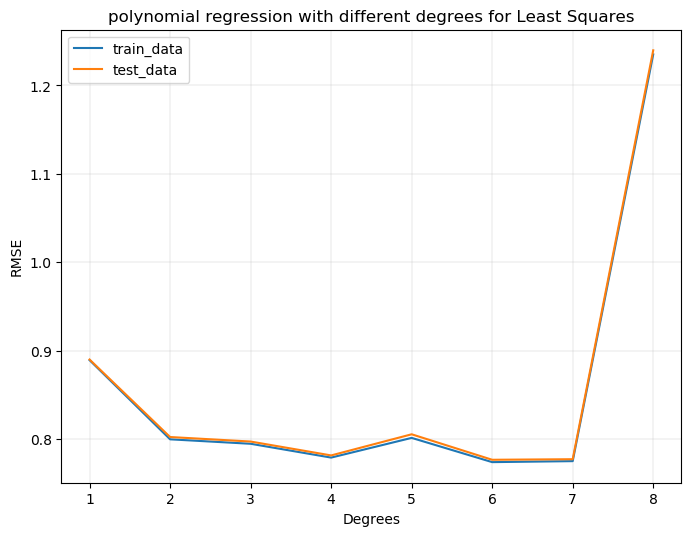

In [33]:
y1 = rmse_tr
y2 = rmse_te
x = np.arange(1,9)
plt.figure(figsize=(8,6),dpi=100)
plt.grid(linestyle='-', linewidth=0.2)
plt.ylabel("RMSE")
plt.title("polynomial regression with different degrees for Least Squares" )
plt.plot(x,y1, label="train_data")
plt.plot(x,y2, label="test_data")
plt.xlabel("Degrees")
plt.legend()
plt.savefig('polynomial regression with different degrees for Least Squares')

In [34]:
def polynomial_regression_lest_squares_ridge(x,y,x0,y0):  # poly
    """Constructing the polynomial basis function expansion of the data,
       and then running least squares regression."""
    # define parameters
    degrees = [1, 2, 3, 4, 5, 6, 7, 8]  # polynomia degree
    rmse_tr = []
    rmse_te = []
    # define the structure of the figure
    
    for ind, degree in enumerate(degrees):
        # form dataset to do polynomial regression.
        tx = feature_aug(x, degree)
        tx0 = feature_aug(x0, degree)

        # least squares
        weights = ridge_regression(y, tx, 0.001)
        mse1 = compute_loss(y, tx, weights)
        mse2 = compute_loss(y0,tx0,weights)
        # compute RMSE
        rmse1 = np.sqrt(2 * mse1) # mse->rmse
        rmse2 = np.sqrt(2 * mse2)
        print("Train Processing {i}th experiment, degree={d}, rmse={loss}".format(
              i=ind + 1, d=degree, loss=rmse1))
        print("Test Processing {i}th experiment, degree={d}, rmse={loss}".format(
              i=ind + 1, d=degree, loss=rmse2))
        rmse_tr.append(rmse1)
        rmse_te.append(rmse2)
    return rmse_tr, rmse_te

In [35]:
rmse_tr0, rmse_te0 = polynomial_regression_lest_squares_ridge(x_tr,y_tr,x_val,y_val)

Train Processing 1th experiment, degree=1, rmse=0.9060852415994366
Test Processing 1th experiment, degree=1, rmse=0.9065898385691725
Train Processing 2th experiment, degree=2, rmse=0.8146857699764614
Test Processing 2th experiment, degree=2, rmse=0.8169728428506993
Train Processing 3th experiment, degree=3, rmse=0.8097668209873035
Test Processing 3th experiment, degree=3, rmse=0.8116858974986154
Train Processing 4th experiment, degree=4, rmse=0.7949297660308983
Test Processing 4th experiment, degree=4, rmse=0.7970826544541255
Train Processing 5th experiment, degree=5, rmse=0.7944611033587241
Test Processing 5th experiment, degree=5, rmse=0.7966663574013605
Train Processing 6th experiment, degree=6, rmse=0.7907848013847099
Test Processing 6th experiment, degree=6, rmse=0.7931199092982899
Train Processing 7th experiment, degree=7, rmse=0.790498645277222
Test Processing 7th experiment, degree=7, rmse=0.792910222758145
Train Processing 8th experiment, degree=8, rmse=0.7899434050636764
Test

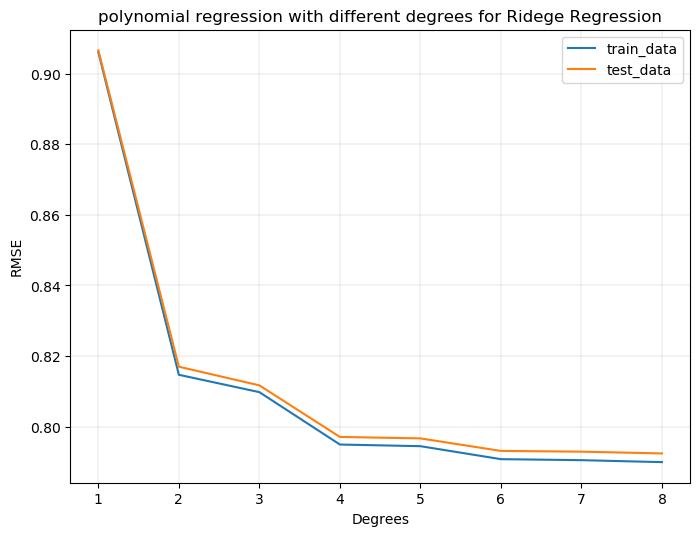

In [36]:
y1 = rmse_tr0
y2 = rmse_te0
x = np.arange(1,9)
plt.figure(figsize=(8,6),dpi=100)
plt.grid(linestyle='-', linewidth=0.2)
plt.ylabel("RMSE")
plt.xlabel("Degrees")
plt.title("polynomial regression with different degrees for Ridege Regression" )
plt.plot(x,y1, label="train_data")
plt.plot(x,y2, label="test_data")
plt.legend()
plt.savefig('polynomial regression with different degrees for Ridege Regression')

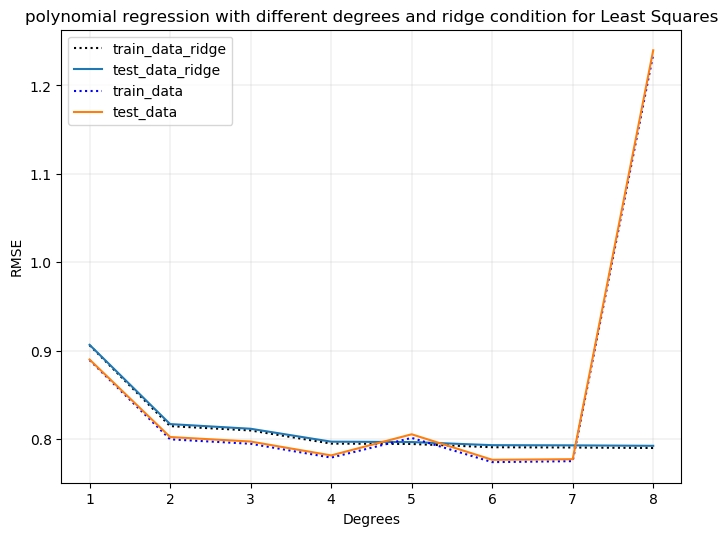

In [37]:
y1 = rmse_tr0
y2 = rmse_te0
y3 = rmse_tr
y4 = rmse_te
x = np.arange(1,9)
plt.figure(figsize=(8,6),dpi=100)
plt.grid(linestyle='-', linewidth=0.2)
plt.ylabel("RMSE")
plt.xlabel("Degrees")
plt.title("polynomial regression with different degrees and ridge condition for Least Squares" )
plt.plot(x,y1, label="train_data_ridge", linestyle=':',c='black')
plt.plot(x,y2, label="test_data_ridge")
plt.plot(x,y3, label="train_data", linestyle=':',c='blue')
plt.plot(x,y4, label="test_data")
plt.legend()
plt.savefig('polynomial regression with different degrees and ridge condition for Least Squares')

In [38]:
# so we now use the degree 8 for ridge regression

In [39]:
y_train, x_train, ids = load_csv_data(r"train.csv", sub_sample=False)
x_train = fix_null(x_train)
x_train = detect_outliers(x_train) # delete outliers
x_train = feature_aug(x_train, 8)
x_train = standlization(x_train) # data standlization
x_train = np.c_[np.ones((x_train.shape[0], 1)), x_train]
x_tr, x_val, y_tr, y_val = split_data(x_train, y_train, 0.75, 99)

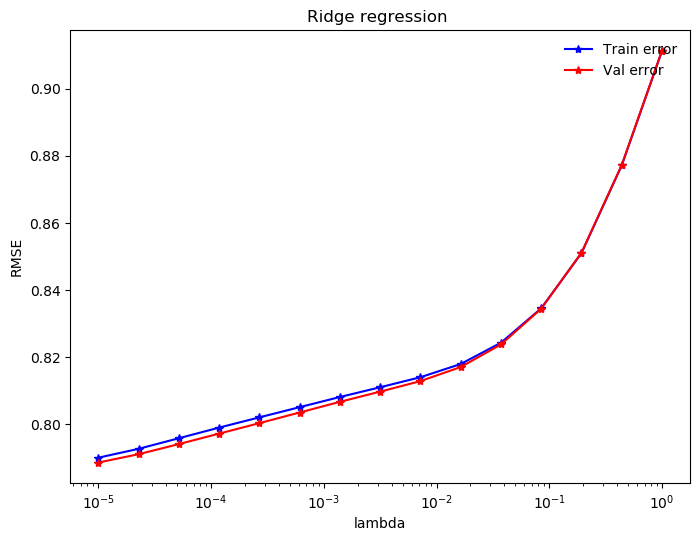

In [40]:
seed = 5
split_ratio = 0.75
plt.figure(figsize=(8,6),dpi=100)
ridge_regression_demo(x_train, y_train,split_ratio, seed)
plt.savefig('ridge regression2')

# step 5 use the cross validation for the best model

we notice that the ridge regression with least squares present the best among these methods and especially great in poly 8, so we use these model for cross validation

In [41]:
y_train, x_train, ids = load_csv_data(r"train.csv", sub_sample=False)
x_train = fix_null(x_train)
x_train = detect_outliers(x_train) # delete outliers
x_train = feature_aug(x_train, 8)
x_train = standlization(x_train)
x_train = np.c_[np.ones((x_train.shape[0], 1)), x_train]

In [42]:
def cross_validation_visualization(lambds, mse_tr, mse_te):
    """visualization the curves of mse_tr and mse_te."""
    plt.semilogx(lambds, mse_tr, marker=".", color='b', label='train error')
    plt.semilogx(lambds, mse_te, marker=".", color='r', label='test error')
    plt.xlabel("lambda")
    plt.ylabel("rmse")
    plt.title("cross validation")
    plt.legend(loc=2)
    plt.grid(True)
    plt.savefig("cross_validation")
    
def cross_validation_test_visualization(lambds, accuracy):
    """visualization the curves of mse_tr and mse_te."""
    plt.semilogx(lambds, accuracy, marker=".", color='b', label='train error')
    plt.xlabel("lambda")
    plt.ylabel("accuracy")
    plt.title("cross validation")
    plt.legend(loc=2)
    plt.grid(True)

def compute_mse(y, tx, w):
    """compute the loss by mse."""
    e = y - tx.dot(w)
    mse = e.dot(e) / (2 * len(e))
    return mse

def _accuracy(Y_pred, Y_label):
    # This function calculates prediction accuracy
    acc = 1 - (np.mean(np.abs(Y_pred - Y_label))/2)
    return acc

def build_k_indices(y, k_fold, seed):
    """build k indices for k-fold."""
    num_row = y.shape[0]
    interval = int(num_row / k_fold) # 给出间隔，分割数据
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval] for k in range(k_fold)]
    return np.array(k_indices)

def cross_validation(y, x, k_indices, k, lambda_):
    """return the loss of ridge regression."""
    # get k'th subgroup in test, others in train
    te_indice = k_indices[k]
    tr_indice = k_indices[~(np.arange(k_indices.shape[0]) == k)] # np.arange()函数一个参数时,参数值为终点,起点取默认值0,
    # np.arange(k_indices.shape[0]) 这里就是[0,1,2,***,indices的行数]；~应该类似取否
    tr_indice = tr_indice.reshape(-1) # 这里应该是把取出来的array[[]]变成array[],记一下，非常的有用
    y_te = y[te_indice]
    y_tr = y[tr_indice]
    x_te = x[te_indice]
    x_tr = x[tr_indice]
    # ridge regression
    w = ridge_regression(y_tr, x_tr, lambda_)
    # calculate the loss for train and test data
    # loss_tr = np.sqrt(2 * compute_mse(y_tr, x_tr, w))
    # loss_te = np.sqrt(2 * compute_mse(y_te, x_te, w))
    y_tr_pred = predict_labels(w, x_tr)
    y_te_pred = predict_labels(w, x_te)
    acc_tr = _accuracy(y_tr_pred, y_tr)
    acc_te = _accuracy(y_te_pred, y_te)
    return w, acc_tr, acc_te

def cross_validation_demo():
    seed = 12
    k_fold = 4
    lambdas = np.logspace(-5, 0, 30)
    # split data in k fold
    k_indices = build_k_indices(y_train, k_fold, seed)
    # define lists to store the loss of training data and test data
    # rmse_tr = []
    # rmse_te = []
    accuracy = []
    acc_r = []
    acc_e = []
    # cross validation
    for lambda_ in lambdas:
        rmse_tr_tmp = []
        rmse_te_tmp = []
        for k in range(k_fold):
            w , acc_tr, acc_te = cross_validation(y_train, x_train, k_indices, k, lambda_)
            # rmse_tr_tmp.append(loss_tr)
            # rmse_te_tmp.append(loss_te)
            # test accuracy
            # y_pred = predict_labels(w, x_val)
            # acc_val = _accuracy(y_pred, y_val)
        # rmse_tr.append(np.mean(rmse_tr_tmp))
        # rmse_te.append(np.mean(rmse_te_tmp))
        
        # accuracy.append(np.mean(acc_val))
        acc_r.append(np.mean(acc_tr))
        acc_e.append(np.mean(acc_te))
    # print(accuracy)
    # cross_validation_visualization(lambdas, rmse_tr, rmse_te)
    # cross_validation_test_visualization(lambdas, _accuracy)
    return accuracy, lambdas, acc_r, acc_e

In [43]:
acc, lam, acc_tr, acc_te = cross_validation_demo()
# plt.semilogx(lam, acc, label = 'test_accuracy')

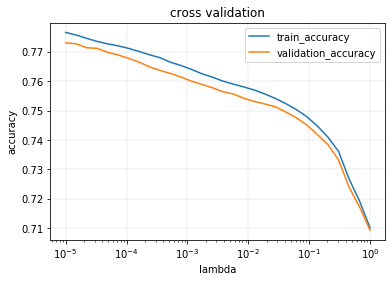

<Figure size 800x600 with 0 Axes>

In [44]:
plt.semilogx(lam, acc_tr, label = 'train_accuracy')
plt.semilogx(lam, acc_te, label = 'validation_accuracy')
plt.xlabel("lambda")
plt.ylabel("accuracy")
plt.title("cross validation")
plt.legend(loc = 'best')
plt.grid(linestyle='-', linewidth=0.2)
plt.figure(figsize=(8,6),dpi=100)
plt.savefig('cross_valid')

# step 6 imporve the accuracy

## group the dataset by PRI_jet_num and use the ridege regression for least squares

In [45]:
def index_search(tx):
    PRI_jet_num_0 = np.where(tx[:,22] == 0)[0]
    PRI_jet_num_1 = np.where(tx[:,22] == 1)[0]
    PRI_jet_num_2 = np.where(tx[:,22] == 2)[0]
    PRI_jet_num_3 = np.where(tx[:,22] == 3)[0]
    return PRI_jet_num_0, PRI_jet_num_1, PRI_jet_num_2, PRI_jet_num_3
    # return ([tx[PRI_jet_num_0,:], tx[PRI_jet_num_1,:], tx[PRI_jet_num_2,:], tx[PRI_jet_num_3,:]],
      #       [y[PRI_jet_num_0], y[PRI_jet_num_1], y[PRI_jet_num_2], y[PRI_jet_num_3]])

def divide(PRI_jet_num_0, PRI_jet_num_1, PRI_jet_num_2, PRI_jet_num_3, tx, y):
    return ([tx[PRI_jet_num_0,:], tx[PRI_jet_num_1,:], tx[PRI_jet_num_2,:], tx[PRI_jet_num_3,:]],
             [y[PRI_jet_num_0], y[PRI_jet_num_1], y[PRI_jet_num_2], y[PRI_jet_num_3]])

In [46]:
y_train, x_train, ids = load_csv_data(r"train.csv", sub_sample=False)
a, b, c, d = index_search(x_train) 
x_train = fix_null(x_train) 
x_train = feature_aug(x_train, 8)
x_train = standlization(x_train)    
x_train = np.c_[np.ones((x_train.shape[0], 1)), x_train]
x_train, y_train = divide(a,b,c,d,x_train,y_train)
x_train = np.array(x_train)
y_train = np.array(y_train)

E:\programming_software\anaconda3\lib\site-packages\ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
E:\programming_software\anaconda3\lib\site-packages\ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if __name__ == '__main__':


In [47]:
ratio = 0.75 # ridge least squre with group by PRI_jet_num
myseed = 1
ws = np.zeros((4,241))
def group_ridege_regression():
    acc_group = 0
    length = 0
    for i in range(4):
        x_tr, x_val, y_tr, y_val = split_data(x_train[i], y_train[i], ratio, myseed)
        w = ridge_regression_demo_new(x_tr, y_tr)
        y_pred = predict_labels(w, x_val)
        ws[i] = w
        acc_group += _accuracy(y_pred, y_val)*x_train[i].shape[0]
        length += x_train[i].shape[0]
    print("The mean average for 4 groups in validation set is ",acc_group/length)
    return ws
ws = group_ridege_regression()

The mean average for 4 groups in validation set is  0.8100986886334643


# step 7 creat submission

In [48]:
y_train, x_train, ids = load_csv_data(r"train.csv", sub_sample=False)
a, b, c, d = index_search(x_train) 
x_train = fix_null(x_train) 
x_train = feature_aug(x_train, 8)
x_train = standlization(x_train)    
x_train = np.c_[np.ones((x_train.shape[0], 1)), x_train]
x_train, y_train = divide(a,b,c,d,x_train,y_train)
x_train = np.array(x_train)
y_train = np.array(y_train)
##################################
ws = np.zeros((4,241))
def group_ridege_regression_2():
    for i in range(4):
        w = ridge_regression_demo_new(x_train[i], y_train[i])
        ws[i] = w
    return ws
ws = group_ridege_regression_2()
##################################
y_test, x_test, ids = load_csv_data(r"test.csv", sub_sample=False)
m,n,k,l = index_search(x_test) 
x_test = fix_null(x_test) 
x_test = feature_aug(x_test, 8)
x_test = standlization(x_test)    
x_test = np.c_[np.ones((x_test.shape[0], 1)), x_test]
x_test, y_test = divide(m,n,k,l,x_test,y_test) 
x_test = np.array(x_test)
y_test = np.array(y_test)

E:\programming_software\anaconda3\lib\site-packages\ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
E:\programming_software\anaconda3\lib\site-packages\ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if __name__ == '__main__':
E:\programming_software\anaconda3\lib\site-packages\ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this,

In [49]:
for i in range(4):
    y_test[i] = predict_labels(ws[i],x_test[i])
index = [m,n,k,l]
length = len(y_test[0]) + len(y_test[1]) + len(y_test[2]) + len(y_test[3])
kk = np.zeros((length))
for i in range(4):
    for j in range(len(index[i])):
        kk[index[i][j]] = y_test[i][j]

In [50]:
create_csv_submission(ids, kk, 'hahaha.csv')